In [10]:
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from itertools import islice
import matplotlib.pyplot as plt

In [11]:
# !rm -rf /content/sample_data
# !cp /content/drive/MyDrive/images.zip /content/
# !unzip -q /content/images.zip -d /content/images/

# FFT analysis

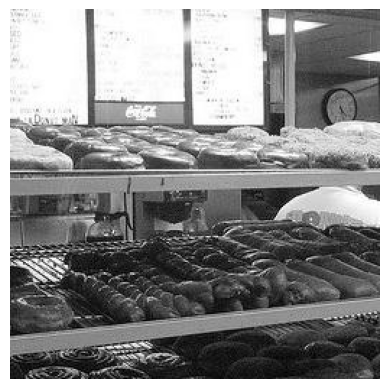

In [12]:
img_dir = Path.cwd() / "images"
img = Image.open(img_dir / "real_proc" / "0001.jpg").convert("L")
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [13]:
def preprocess_imgs(input_dir, output_dir, dims=(256,256), total=None):
    output_dir.mkdir(exist_ok=True)

    img_paths = sorted(input_dir.glob("*.jpg"), key=lambda p: int(p.stem))
    pbar = tqdm(total=total if total is not None else len(img_paths))
    count = 0

    for img_path in img_paths:
        pbar.update(1)
        # We have to handle total this way because we don't know how many images will be skipped
        if total is not None and count >= total:
            break

        with Image.open(img_path) as img:
            img = img.convert("L")
            w, h = img.size

            # Sort out images smaller than desired in any of dimensions
            if w < dims[0] or h < dims[1]:
                continue

            w_start = random.randint(0, w - dims[0])
            h_start = random.randint(0, h - dims[1])

            # left, top, right, bottom
            cropped_img = img.crop((w_start, h_start, w_start + dims[0], h_start + dims[1]))
            cropped_img.save(output_dir / f"{img_path.stem}.jpg")

            count += 1

    pbar.close()

In [14]:
# # With default total=None, process all images in the folders
# preprocess_imgs(img_dir / "real", img_dir / "real_proc")
# preprocess_imgs(img_dir / "gen", img_dir / "gen_proc")

In [15]:
def calc_magnitude_spect(img):
    # 2D FFT of the image array
    fft = np.fft.fft2(img)
    fft_shifted = np.fft.fftshift(fft)  # Move zero frequency to center

    # Magnitude spectrum
    mag = np.abs(fft_shifted)
    mag_log = np.log1p(mag)  # Log scale for visibility

    return mag_log

In [16]:
def calc_radial_prof(arr):
    # Calculate radial distances from the image centre
    h, w = arr.shape
    rows, cols = np.indices((h, w))
    cy = (h - 1) / 2
    cx = (w - 1) / 2
    radial_dists = np.sqrt((rows - cy)**2 + (cols - cx)**2)
    r = radial_dists.astype(int)

    # Calculate sum of pixel values at a certain radius and divide by number of bins at that radius
    sum_bins = np.bincount(r.ravel(), weights=arr.ravel())
    num_bins = np.bincount(r.ravel())
    radial_prof = sum_bins / num_bins

    return radial_prof

In [17]:
def get_rp_arrays(img_dir, total=None):
    rps = []
    img_paths = islice(img_dir.glob("*.jpg"), total)

    for img_path in img_paths:

        img = Image.open(img_path)
        rp = calc_radial_prof(calc_magnitude_spect(img))
        rps.append(rp)

    return rps

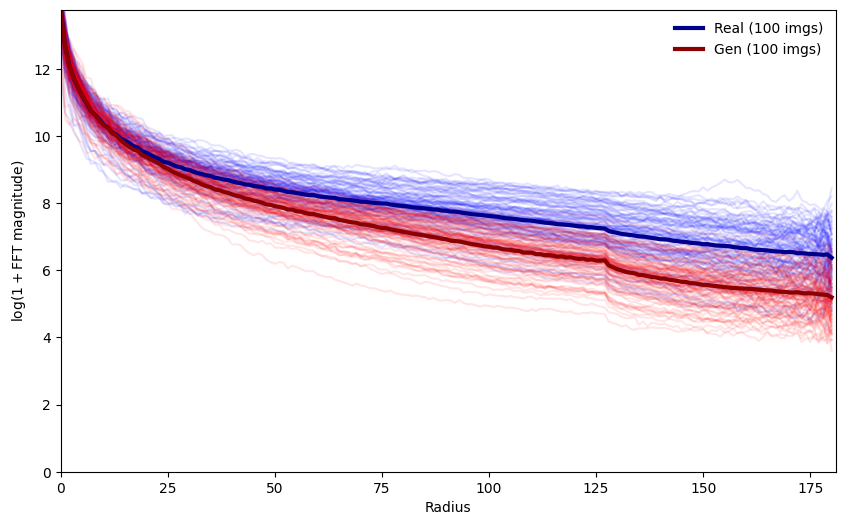

In [18]:
rps_real = get_rp_arrays(img_dir / "real_proc", total=100)
rps_gen = get_rp_arrays(img_dir / "gen_proc", total=100)

plt.figure(figsize=(10,6))

for rp in rps_real:
    plt.plot(rp, color='b', alpha=0.1)

for rp in rps_gen:
    plt.plot(rp, color='r', alpha=0.1)

# Plot array-wise averages of the 2D array
rp_real_avg = np.mean(rps_real, axis=0)
rp_gen_avg = np.mean(rps_gen, axis=0)

plt.plot(rp_real_avg, color='darkblue', linewidth=3, label=f"Real ({len(rps_real)} imgs)")
plt.plot(rp_gen_avg, color='darkred', linewidth=3, label=f"Gen ({len(rps_gen)} imgs)")
plt.ylim(0, max(rp_real_avg.max(), rp_gen_avg.max()))
plt.xlim(0, len(rp_real_avg))
plt.legend(frameon=False)
plt.ylabel(r"$\log(1 + \text{FFT magnitude})$")
plt.xlabel("Radius")
plt.show()

FFT shifts image data from the spatial into the frequency domain. By decomposing the image into its constituent sinusoidal components, we get a magnitude spectrum where the centre represents low-frequencies (slow transitions, shapes) and the periphery represents high-frequencies (fine details, noise, edges). The radial profile is then calculated by averaging the magnitude values at each radius from the centre.

A drop in both curves at radius 128 is a border effect, as beyond that radius, higher radius samples will only be limited to the diagonal corners, and diagonals in natural images typically contain less energy than the axes.

https://www.mdpi.com/2078-2489/15/11/711

# CNN

In [19]:
import copy
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [20]:
total = 5000

real_dir = Path.cwd() / "images" / "real_proc"
gen_dir = Path.cwd() / "images" / "gen_proc"

# Take images from the start of the sorted list to keep dataset balanced
# key is a function to execute to decide the order
# .stem works only with pathlib objects
real_paths = list(sorted(real_dir.glob("*.jpg"), key=lambda p: int(p.stem)))[:total]
gen_paths = list(sorted(gen_dir.glob("*.jpg"), key=lambda p: int(p.stem)))[:total]

df_real = pd.DataFrame({"path": real_paths, "label": 0})
df_gen = pd.DataFrame({"path": gen_paths, "label": 1})
df_all = pd.concat([df_real, df_gen], ignore_index=True)

pd.set_option('display.max_colwidth', None)
display(df_all.head())

,path,label
0,/content/images/real_proc/0000.jpg,0
1,/content/images/real_proc/0001.jpg,0
2,/content/images/real_proc/0002.jpg,0
3,/content/images/real_proc/0003.jpg,0
4,/content/images/real_proc/0004.jpg,0


In [21]:
df_train, df_temp = train_test_split(df_all, test_size=0.3, stratify=df_all["label"], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp["label"], random_state=42)

In [22]:
class ImageDataset(Dataset):
    """
    DataLoader calls df[i], which in pandas looks up a column, not a row. It requires a Dataset
    where __getitem__ uses positional indexing via .iloc, or data converted to tensors/ arrays
    (preloading all images, unlike a Dataset class which loads and transforms them on the fly).
    __len__ is needed to know the number of samples.
    """
    def __init__(self, df, trans=False, p_flip=0.3, p_bright=0.3):
        self.df = df.reset_index(drop=True)
        self.trans = trans
        self.p_flip = p_flip
        self.p_bright = p_bright

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        path = self.df.loc[i, "path"]
        label = self.df.loc[i, "label"]

        img = Image.open(path)
        img = np.array(img, dtype=np.float32) / 255.0  # shape (H, W)

        if self.trans:
            if random.random() < self.p_flip:
                img = np.flip(img, axis=1)
            if random.random() < self.p_bright:
                factor = random.uniform(0.8, 1.2)
                img = np.clip(img * factor, 0.0, 1.0)

        fft = np.fft.fft2(img)
        fft = np.fft.fftshift(fft)
        fft_mag = np.log1p(np.abs(fft))
        fft_mag = (fft_mag - fft_mag.mean()) / fft_mag.std()  # shape (H, W)

        x = np.stack([img, fft_mag], axis=0)  # shape (2, H, W)
        x = torch.from_numpy(x).float()

        return x, label

In [23]:
train_ds = ImageDataset(df_train, trans=True)
val_ds = ImageDataset(df_val)
test_ds = ImageDataset(df_test)

In [24]:
class SimpleCNN(nn.Module):
    """
    1st layer: 1 input channel (greyscale image), 16 output channels (feature maps),
    3×3 kernels initialised randomly and learned during training.

    params = in_ch * out_ch * kernel h * kernel w + one bias per out_ch
    e.g.: 2 * 16 * 3 * 3 + 16 = 304
          16 * 32 * 3 * 3 + 32 = 4640

    nn.MaxPool2d(2, 2) has kernel size 2×2 and stride 2×2, reduces spacial dims by half.

    self.fc maps 64 neurons to 2 output classes
    """
    def __init__(self):
        # super() in Python calls methods of a parent class
        super().__init__()
        self.conv1 = nn.Conv2d(2, 16, 3, padding="same")
        self.conv2 = nn.Conv2d(16, 32, 3, padding="same")
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.conv4 = nn.Conv2d(64, 128, 3, padding="same")


        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)

        self.mpool = nn.MaxPool2d(2, 2)
        self.apool = nn.AdaptiveAvgPool2d((4,4))
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(2048, 1)

    def forward(self, x):
        x = self.mpool(F.relu(self.bn1(self.conv1(x))))
        x = self.mpool(F.relu(self.bn2(self.conv2(x))))
        x = self.mpool(F.relu(self.bn3(self.conv3(x))))
        x = self.mpool(F.relu(self.bn4(self.conv4(x))))

        x = self.apool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x).squeeze(1)

In [25]:
# -1 is a placeholder for the batch size
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN().to(device)
summary(model, input_size=(2, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             304
       BatchNorm2d-2         [-1, 16, 256, 256]              32
         MaxPool2d-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           4,640
       BatchNorm2d-5         [-1, 32, 128, 128]              64
         MaxPool2d-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          18,496
       BatchNorm2d-8           [-1, 64, 64, 64]             128
         MaxPool2d-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]          73,856
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        MaxPool2d-12          [-1, 128, 16, 16]               0
AdaptiveAvgPool2d-13            [-1, 128, 4, 4]               0
          Dropout-14                 [-

In [26]:
def train_model(train_ds, val_ds, batch_size, lr_init, wd, n_epochs, patience):

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    model = SimpleCNN().to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr_init, weight_decay=wd)
    crit = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=2)

    # Set up lists to track losses
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # Set model to training mode
        model.train()
        train_loss = 0.0

        for bat_x, bat_y in train_loader:
            bat_x, bat_y = bat_x.to(device), bat_y.to(device)

            # Forward pass
            outputs = model(bat_x) # Randomly initialised by PyTorch by default the first time it runs
            loss = crit(outputs, bat_y.float())

            # Backward pass
            optim.zero_grad()   # Clear previous gradients
            loss.backward()     # Compute gradients
            optim.step()        # Update parameters

            train_loss += loss.item()

        # Record average training loss for this epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Set model to evaluation mode and evaluate on the validation set
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for bat_x, bat_y in val_loader:
                bat_x, bat_y = bat_x.to(device), bat_y.to(device)

                outputs = model(bat_x)
                loss = crit(outputs, bat_y.float())

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        print(f"Epoch {epoch + 1:>2}/{n_epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, lr: {optim.param_groups[0]['lr']}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after epoch {epoch + 1}")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses

In [27]:
model, train_losses, val_losses = train_model(train_ds, val_ds, batch_size=64, lr_init=1e-4, wd=1e-5, n_epochs=100, patience=6)

Epoch  1/100, train loss: 0.3999, val loss: 0.3509, lr: 0.0001
Epoch  2/100, train loss: 0.3611, val loss: 0.3280, lr: 0.0001
Epoch  3/100, train loss: 0.3537, val loss: 0.3183, lr: 0.0001
Epoch  4/100, train loss: 0.3416, val loss: 0.3140, lr: 0.0001
Epoch  5/100, train loss: 0.3286, val loss: 0.3051, lr: 0.0001
Epoch  6/100, train loss: 0.3228, val loss: 0.3029, lr: 0.0001
Epoch  7/100, train loss: 0.3202, val loss: 0.3142, lr: 0.0001
Epoch  8/100, train loss: 0.3157, val loss: 0.2924, lr: 0.0001
Epoch  9/100, train loss: 0.3092, val loss: 0.3211, lr: 0.0001
Epoch 10/100, train loss: 0.3075, val loss: 0.2858, lr: 0.0001
Epoch 11/100, train loss: 0.2982, val loss: 0.2839, lr: 0.0001
Epoch 12/100, train loss: 0.2936, val loss: 0.2968, lr: 0.0001
Epoch 13/100, train loss: 0.2909, val loss: 0.2726, lr: 0.0001
Epoch 14/100, train loss: 0.2818, val loss: 0.2680, lr: 0.0001
Epoch 15/100, train loss: 0.2871, val loss: 0.3100, lr: 0.0001
Epoch 16/100, train loss: 0.2773, val loss: 0.2641, lr:

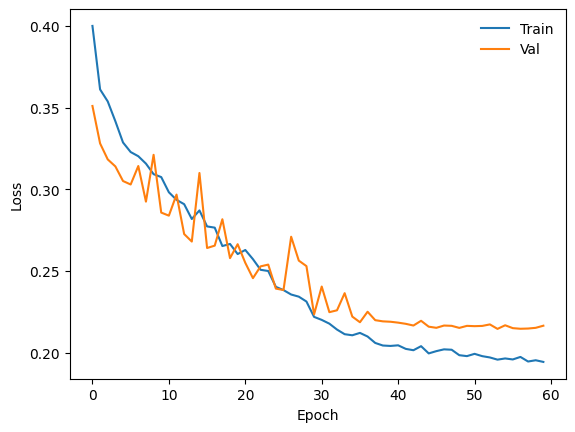

In [28]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [29]:
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

y_true, y_pred, probs = [], [], []
model.eval()
th = 0.5

with torch.no_grad():
    for bat_x, bat_y in test_loader:
        bat_x, bat_y = bat_x.to(device), bat_y.to(device)

        logits = model(bat_x)
        prob = torch.sigmoid(logits)

        y_true.append(bat_y.cpu().numpy())
        y_pred.append((prob > th).int().cpu().numpy())
        probs.append(prob.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
probs = np.concatenate(probs)

In [30]:
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Confusion matrix:\n{cm}")
print(f"Accuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")

Confusion matrix:
[[677  67]
 [ 49 701]]
Accuracy: 0.922
F1 Score: 0.924


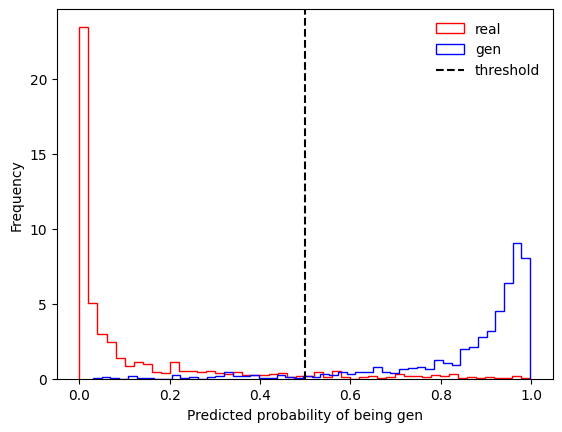

In [31]:
plt.hist(probs[y_true == 0], bins=50, density=True, histtype='step', color='r', label = 'real')
plt.hist(probs[y_true == 1], bins=50, density=True, histtype='step', color='b', label = 'gen')
plt.axvline(x=th, color='k', linestyle='--', label='threshold')
plt.xlabel("Predicted probability of being gen")
plt.ylabel("Frequency")
plt.legend(frameon=False, loc='upper right')
plt.show()